# Support Vector Machines and Feature Selection
---

In [1]:
# This is useful for plotting in jupyter notebooks only
%matplotlib inline

In [2]:
import pandas as pd
import sklearn.preprocessing
import sklearn.utils
import sklearn.metrics
import sklearn.model_selection
import sklearn.svm
import matplotlib.pyplot as plt
import numpy as np
import itertools
from IPython.display import HTML, display
from datetime import datetime

### Read in the Data

---

It's important to remember to set the header to `None` here since the spambase.data csv does not have a header. Also, setting `index_col=57` will make it so the class, the true values, will be the index of the dataframe.

In [3]:
data = pd.read_csv('~/data/spam.data/spambase.data', header=None, index_col=57)

### Split the Data
---
Use `sklearn.model_selection.train_test_split()` to shuffle and split the data set in half.

In [23]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data,
                                                                            data.index.values, 
                                                                            test_size=0.5)

### Scale the Data
---
Here we want to compute the mean and standard deviation over the columns of the training set. Then we want to subtract out the mean and divide by the standard deviation for each item in the column. The trick is that we want to scale the test set with the mean and standard deviation of the training set. The `sklearn.preprocessing.StandardScaler()` suits our needs here. The `fit()` function will calculate the mean and standard deviation of the set passed as an argument. The `transform()` function will do the required computation on the set and return a new set with the result.

In [24]:
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=y_train)
X_test = pd.DataFrame(scaler.transform(X_test), index=y_test)

## Experiment 1
---
### Set up the linear Support Vector Machine Classifier
This is the entirety of training a SVM using scikit learn. I tend to get accuracies in the 90% to 92% range.

In [25]:
clf = sklearn.svm.SVC(kernel='linear').fit(X_train, y_train)
print('SVM Accuracy: {acc:.4f}'.format(acc=clf.score(X_test, y_test)))

SVM Accuracy: 0.9322


### Calculate and Plot the ROC Curve
---
Note that to calculate the ROC Curve, we need the result of the classifier's decision function. You can get this by simply calling `clf.decision_function()` or the testing instances.

In [26]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true=y_test,
                                                 y_score=clf.decision_function(X_test),
                                                 pos_label=1)

In [27]:
def plot_roc_curve(fpr, tpr, auc):
    """
    Take a list of False Positive Rates, True Positive Rates, and an Area Under the Curve value
    and output an ROC curve using matplotlib.
    """
    plt.figure(figsize=(8,8))
    lw = 2
    plt.plot(fpr, tpr, color='red', lw=lw, label='ROC curve')
    plt.plot([0,1], [0,1], color='lightblue', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver Operating Characteristic', fontsize=24)
    plt.legend(loc='lower right', fontsize=12)
    plt.axes().set_aspect('equal', 'datalim')
    plt.text(0.5, 0.5, 
             'AUC: {:.4f}'.format(auc), 
             bbox=dict(facecolor='black'), 
             horizontalalignment='center', 
             fontsize=18)
    plt.style.use('dark_background')
    plt.show()

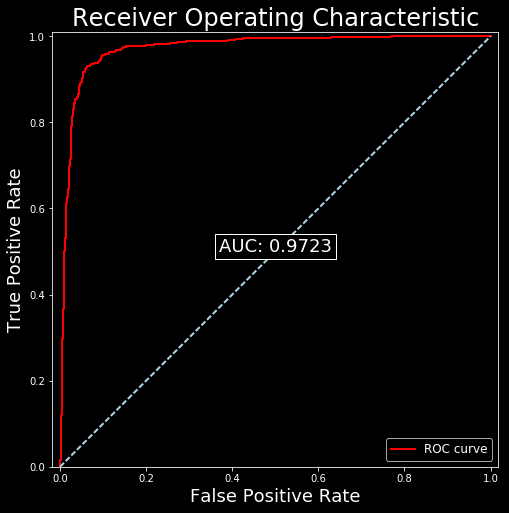

In [28]:
plot_roc_curve(fpr, 
               tpr, 
               sklearn.metrics.roc_auc_score(y_true=y_test,
                                             y_score=clf.decision_function(X_test)))

### Calculate and Plot the Confusion Matrix
---
Use the `sklearn.metrics.confusion_matrix()` function to calculate the confusion matrix and use matplotlib to plot it.

In [29]:
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred=clf.predict(X_test))

In [30]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=28)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=24)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.style.use('dark_background')
    plt.show()

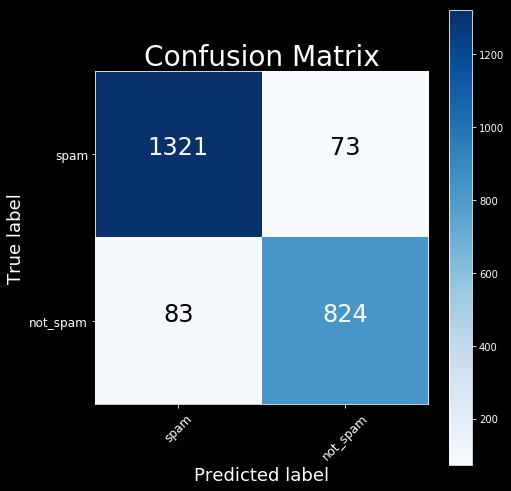

In [31]:
plot_confusion_matrix(cnf_matrix, classes=('spam', 'not_spam'), title='Confusion Matrix')

## Experiment 2 and 3
---
### Experiment 2: Feature Selection
* Using the learned SVM model from Experiment 1, obtain the weight vector (found in `clf.coef_`)
* for $m=2$ to $57$
  * select the set of $m$ features that have highest $|w_m|$
  * Train a linear SVM, $SVM_m$, on all the training data only using these $m$ features.
  * Test $SVM_m$ on the test set (using the same $m$ features) to obtain accuracy.
* Plot accuracy vs $m$

### Experiment 3: Random Feature Selection
Same as experiment 2, but for each $m$, select $m$ features at random from the complete set. This is to see if using SVM weights for feature selection has any advantage over random.

In [32]:
# First, train the SVM classifier on a random data set multiple times to determine
# which features consistently have the highest weights.

counts = [0] * 57

for i in range(100):
    if i % 10 == 0:
        print('{i}: {dt}'.format(i=i, dt=datetime.now()))
        
    #Split the data into a random training set, ignoring the test sets for now
    X_t, _, y_t, _ = sklearn.model_selection.train_test_split(data,
                                                              data.index.values, 
                                                              test_size=0.5)
    # We still must preprocess the data in the training set
    s = sklearn.preprocessing.StandardScaler().fit(X_t)
    X_t = pd.DataFrame(scaler.transform(X_t), index=y_t)
    
    # Train the classifier
    c = sklearn.svm.SVC(kernel='linear').fit(X_t, y_t)
    
    # Get a list of indexes of the resulting weight vector sorted from most to least
    w = np.flip(np.argsort(np.abs(c.coef_.ravel())), 0)

    # Increment the counts array at each index by a descending amount
    for j, index in enumerate(w):
        counts[index] += (len(w) - j)


0: 2017-02-25 22:54:21.946873
10: 2017-02-25 22:54:24.889257
20: 2017-02-25 22:54:27.234200
30: 2017-02-25 22:54:29.719502
40: 2017-02-25 22:54:32.081791
50: 2017-02-25 22:54:35.037697
60: 2017-02-25 22:54:37.919283
70: 2017-02-25 22:54:40.713122
80: 2017-02-25 22:54:43.709283
90: 2017-02-25 22:54:46.563112


In [33]:
def gen_arr_list(array, m=2):
    """
    Return a generator that will add another feature to the set of features each time.
    """
    return (array[0:i] for i in range(m, len(array)))

In [34]:
# np.argsort() returns a numpy array of the indexes in sorted order
# np.flip() reverses the array along the specified axis.
feature_indexes_sorted_by_abs_weight = np.flip(np.argsort(counts), 0)
# np.random.permutation() returns a permutation of the argument array
# np.arange() generates a numpy array in a specified range.
feature_indexes_shuffled = np.random.permutation(np.arange(clf.coef_.shape[1]))

# This list comprehension takes a set of column indexes, trains a new SVM on just those columns,
# calculates the accuracy of that SVM, and then appends the accuracy to the list. The X_test and
# X_train items are pandas DataFrames. To select all rows of a set of columns, you can use the 
# loc[] method and pass `:` to select all the rows, and a list of columns.
best_abs_accuracies = [
    sklearn.svm.SVC(kernel='linear')
    .fit(X_train.loc[:, cols], y_train)
    .score(X_test.loc[:, cols], y_test) 
    for cols in gen_arr_list(feature_indexes_sorted_by_abs_weight)
]

# This does the same thing but for the indexes of random features.
random_accuracies = [
    sklearn.svm.SVC(kernel='linear')
    .fit(X_train.loc[:, cols], y_train)
    .score(X_test.loc[:, cols], y_test)
    for cols in gen_arr_list(feature_indexes_shuffled)
]

In [35]:
names = pd.read_csv('~/data/spam.data/feature.names', header=None)
df = pd.DataFrame(list(zip(names.loc[feature_indexes_sorted_by_abs_weight[:10]].values.ravel(),
                           names.loc[feature_indexes_shuffled[:10]].values.ravel())), 
                  columns=('Top 10 Weighted Features', 'First 10 Random Features'))
display(HTML(df.to_html(index=False)))

Top 10 Weighted Features,First 10 Random Features
word_freq_george,word_freq_make
word_freq_hp,capital_run_length_total
capital_run_length_longest,word_freq_george
char_freq_$,word_freq_order
word_freq_edu,capital_run_length_average
word_freq_cs,char_freq_(
word_freq_meeting,word_freq_labs
word_freq_free,word_freq_415
word_freq_85,word_freq_money
word_freq_hpl,word_freq_internet


### Compare the Results in the Same Graph

In [36]:
def plot_accuracy_graphs(b, r):
    plt.figure(figsize=(16,8))
    lw=2
    plt.plot(range(len(b)), b, lw=lw, color='red')
    plt.plot(range(len(r)), r, lw=lw, color='lightblue')
    plt.ylim([min(min(b), min(r)) - 0.01, max(max(b), max(r)) + 0.01])
    plt.annotate('Best Features', xy=(10, b[10]), xytext=(-1, b[10] + 0.015), fontsize=16,
                 arrowprops=dict(facecolor='white', shrink=0.1, width=1, headwidth=10, headlength=10))
    plt.annotate('Features chosen at random', xy=(20, r[20]), xytext=(22, r[20] - 0.05), fontsize=16,
                 arrowprops=dict(facecolor='white', shrink=0.1, width=1, headwidth=10, headlength=10))
    plt.show()

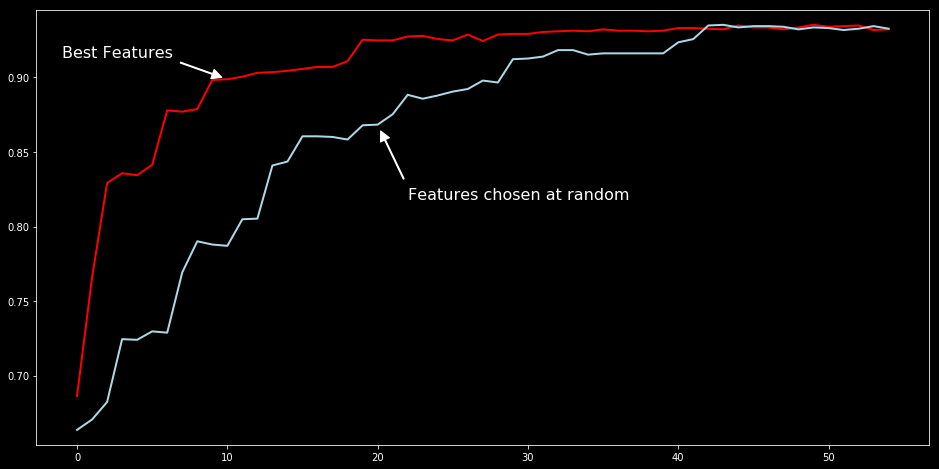

In [37]:
plot_accuracy_graphs(best_abs_accuracies, random_accuracies)